# S2S Kenya - Zonal statistics

Zonal statistics are run on the standardized [H3 grid](https://h3geo.org/docs/core-library/restable/); the process is run on a country-by-country basis.

For the zonal statistics, each zonal statistic is run against the source dataset as a whole, then it is stratified by urban classification from the European Commission - [GHS-SMOD](https://ghsl.jrc.ec.europa.eu/ghs_smod2019.php). This creates an summary dataset that has the standard zonal stats columns (SUM, MEAN, MAX, MIN) as well as the same for urban areas (SUM_urban, MEAN_urban, MAX_urban, MIN_urban).

In [1]:
import sys, os, importlib, math, multiprocessing
import rasterio, geojson

import pandas as pd
import geopandas as gpd
import numpy as np

from h3 import h3
from tqdm import tqdm
from shapely.geometry import Polygon

sys.path.insert(0, "/home/wb411133/Code/gostrocks/src")
import GOSTRocks.rasterMisc as rMisc
import GOSTRocks.ntlMisc as ntl
import GOSTRocks.mapMisc as mapMisc
from GOSTRocks.misc import tPrint

sys.path.append("../../../src")
import h3_helper
import country_zonal

%load_ext autoreload
%autoreload 2

/home/wb411133/.conda/envs/ee/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Define baseline data
h3_level = 6
admin_bounds = "/home/public/Data/GLOBAL/ADMIN/ADMIN2/HighRes_20230328/shp/WB_GAD_ADM2.shp"
out_folder = f"/home/wb411133/projects/Space2Stats/"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)


In [3]:
inA = gpd.read_file(admin_bounds)
regionalA = inA.loc[inA['WB_REGION'] == 'LCR'].copy()
regionalA['ID'] = regionalA.index #Create ID for indexing



In [9]:
### Define raster data to summarize
ntl_files = ntl.aws_search_ntl()
global_urban = "/home/public/Data/GLOBAL/GHSL/SMOD/GHS_SMOD_E2020_GLOBE_R2023A_54009_1000_V1_0.tif"
global_population = "/home/public/Data/GLOBAL/Population/WorldPop_PPP_2020/WP_2020_100m.vrt"

# Generate zonal statistics at h3 for each country in LCR

In [5]:
all_args = {}

for idx, row in regionalA.iterrows():
    sel_iso3 = row['ISO_A3']
    geo_row = gpd.GeoDataFrame(pd.DataFrame(row).transpose(), geometry='geometry', crs=regionalA.crs)
    out_folder = f"s3://wbg-geography01/Space2Stats/h3_spatial_data/LCR/{sel_iso3}/"
    zonalC = country_zonal.country_h3_zonal(sel_iso3, geo_row, "ID", 6, out_folder)
    all_args[sel_iso3] = zonalC
    break
    

In [6]:
all_args

{'ARG': <country_zonal.country_h3_zonal at 0x7fce7b2cd280>}

In [7]:
def get_per(x):
    try:
        return(x['SUM_urban']/x['SUM'] * 100)
    except:
        return(0)

## Population

In [ ]:
global_pop_layer = "/home/public/Data/GLOBAL/GHSL/Pop/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0.tif"
#popR = rasterio.open(global_pop_layer)
#popR.profile

In [ ]:
zonalC = country_zonal.country_h3_zonal(sel_iso3, selA, "ID", h3_level, out_folder)
zonal_res_pop = zonalC.zonal_raster_urban(global_pop_layer, global_urban)

In [ ]:
map_data_pop = zonal_res_pop.sort_values("SUM_urban").loc[:,['shape_id','SUM','SUM_urban']].copy()
map_data_pop = pd.merge(zonalC.h3_cells, map_data_pop, on='shape_id')
map_data_pop['per_urban'] = map_data_pop.apply(get_per, axis=1)
map_data_pop.sort_values('SUM', ascending=False)

In [ ]:
map_plt = mapMisc.static_map_vector(map_data_pop, "SUM", thresh=[50, 1000, 5000, 10000, 50000, 100000, 500000, 1500000], figsize=(15, 15))
map_plt.title("Total population")
map_plt.show()

In [ ]:
map_plt = mapMisc.static_map_vector(map_data_pop, "per_urban", thresh=[0, 20, 40, 60, 80, 100, 1000], figsize=(15,15))
map_plt.title("Percent population in urban areas")
map_plt.show()

## Nighttime Lights

In [11]:
dir(zonalC)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'adm_bounds',
 'adm_bounds_id',
 'generate_h3_grid',
 'h3_cells',
 'h3_level',
 'iso3',
 'out_admin',
 'out_folder',
 'out_h3_grid',
 'summarize_adm_h3_join',
 'write_output',
 'zonal_raster_population',
 'zonal_raster_urban']

In [10]:
zonalC = all_args['ARG']
ntl_file = ntl_files[-1]

zonal_res = zonalC.zonal_raster_urban(ntl_file, global_urban)
map_data = zonal_res.sort_values("SUM_urban").loc[:,['shape_id','SUM','SUM_urban']].copy()
map_data = pd.merge(zonalC.h3_cells, map_data, on='shape_id')
map_data['per_urban'] = map_data.apply(get_per, axis=1)
map_data.sort_values('SUM', ascending=False).head()

(1, 215, 331)


,index,shape_id,index_right,ID,geometry,SUM,SUM_urban,per_urban
0,86435c0c7ffffff,86435c0c7ffffff,0,0,"POLYGON ((63.81939 32.14221, 63.82920 32.10851...",-1,-1.0,100.0
10677,864342327ffffff,864342327ffffff,0,0,"POLYGON ((62.71817 32.95434, 62.72864 32.92055...",-1,-1.0,100.0
10664,86434379fffffff,86434379fffffff,0,0,"POLYGON ((63.82471 32.89050, 63.83462 32.85659...",-1,-1.0,100.0
10665,86435b06fffffff,86435b06fffffff,0,0,"POLYGON ((66.19029 31.27388, 66.19880 31.24016...",-1,-1.0,100.0
10666,86435d62fffffff,86435d62fffffff,0,0,"POLYGON ((65.15876 32.53485, 65.16796 32.50087...",-1,-1.0,100.0


/home/wb411133/.conda/envs/ee/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fce1e067680>

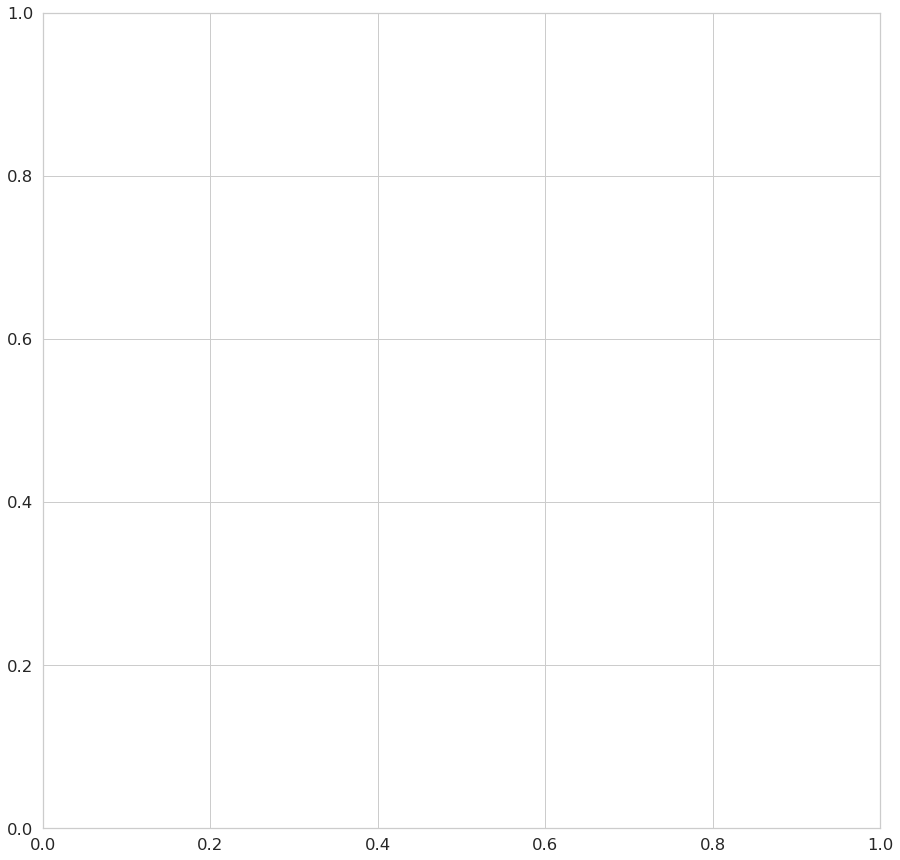

In [12]:
map_plt = mapMisc.static_map_vector(map_data, "SUM", thresh=[50,100,500,1000,7000], figsize=(15,15))
map_plt.title("Total Nighttime Brightness")
map_plt.show()

In [ ]:
map_plt = mapMisc.static_map_vector(map_data, "per_urban", figsize=(15,15))
map_plt.title("Percent nighttime lights in urban areas")
map_plt.show()

## Flood Depth

In [ ]:
flood_depth = '/home/public/Data/GLOBAL/FLOOD_SSBN/v2_2019/Kenya/fluvial_undefended/FU_1in1000.tif'
zonalC = country_zonal.country_h3_zonal(sel_iso3, selA, "ID", h3_level, out_folder)
zonal_res = zonalC.zonal_raster_urban(flood_depth, global_urban, minVal=0, maxVal=10)

map_data = zonal_res.sort_values("SUM_urban").loc[:,['shape_id','SUM','SUM_urban']].copy()
map_data = pd.merge(zonalC.h3_cells, map_data, on='shape_id')
map_data['per_urban'] = map_data.apply(get_per, axis=1)
map_data.sort_values('SUM', ascending=False).head()

In [ ]:
map_plt = mapMisc.static_map_vector(map_data, "SUM", thresh=[0,100,500,1000,5000,15000], figsize=(15,15))
map_plt.title("Total flood depth")
map_plt.show()

In [ ]:
# Use flooding as mask for summing population
flood_r = rasterio.open(flood_depth)
flood_data = flood_r.read()
flood_data = ((flood_data > 0) * (flood_data < 100)).astype(int)
'''
flood_mask_file = os.path.join(out_folder, os.path.basename(flood_depth).replace(".tif", "_mask.tif"))
with rasterio.open(flood_mask_file, 'w', **flood_r.profile) as out_flood:
    out_flood.write(flood_data)
flood_mask = rasterio.open(flood_mask_file)
zonal_res = zonalC.zonal_raster_urban(global_pop_layer, flood_mask, minVal=0, urban_mask_val=[1])
'''
with rMisc.create_rasterio_inmemory(flood_r.profile, flood_data) as flood_mask:
    zonal_res_pop = zonalC.zonal_raster_urban(global_pop_layer, flood_mask, minVal=0, urban_mask_val=[1])

map_data_pop = zonal_res_pop.sort_values("SUM_urban").loc[:,['shape_id','SUM','SUM_urban']].copy()
map_data_pop = pd.merge(zonalC.h3_cells, map_data_pop, on='shape_id')
map_data_pop['per_urban'] = map_data_pop.apply(get_per, axis=1)
map_data_pop.sort_values('SUM', ascending=False).head()

In [ ]:
map_plt = mapMisc.static_map_vector(map_data_pop, "SUM", figsize=(15,15), thresh=[1,5000,10000,50000,100000,10000000],edgecolor="match")
map_plt.title("Population exposed to flood")
map_plt.show()

In [ ]:
map_plt = mapMisc.static_map_vector(map_data_pop, "per_urban", figsize=(15,15), thresh=[1,25,50,70,90,100],edgecolor="match")
map_plt.title("Percent of population exposed to flood")
map_plt.show()

# Join h3 zonal results to admin boundaries

below we compare timing the administrative summaries with and without fractional intersections. While there is a difference between the two, the overall process is quite fast. As the is no computational limitation, we will rely on the fractional intersection as it is more accurate.

In [ ]:
### These two cells are used to test the speed of joining with and without
# %timeit cur_res = country_zonal.connect_polygons_h3_stats(selA, zonal_res, h3_level, "ID", True)

In [ ]:
# %timeit cur_res = country_zonal.connect_polygons_h3_stats(selA, zonal_res, h3_level, "ID", False)

In [ ]:
cur_res = country_zonal.connect_polygons_h3_stats(selA, zonal_res_pop, h3_level, "ID", True)

In [ ]:
map_admin = pd.merge(selA, cur_res, left_on="ID", right_on='id')
map_admin['per_urban'] = map_admin.apply(get_per, axis=1)

In [ ]:
map_plt = mapMisc.static_map_vector(map_admin, "SUM", figsize=(15,15))
map_plt.title("Total Population")
map_plt.show()

In [ ]:
map_plt = mapMisc.static_map_vector(map_admin, "per_urban", figsize=(15,15))
map_plt.title("Percent uban population")
map_plt.show()

# DEBUGGING

In [ ]:
global_pop_layer = "/home/public/Data/GLOBAL/GHSL/Pop/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0.tif"
popR = rasterio.open(global_pop_layer)
#popR.profile
rMisc.clipRaster(popR, zonalC.h3_cells, os.path.join(out_folder, os.path.basename(global_pop_layer)))